## From the previous session

***Exercise (homework)***: Use the code examples above to create a series of 100 model runs in which the pan factor, rainfall chloride concentration as well as the measured rainfall, evaporation and the dam water volume are all stochastic parameters.

In [1]:
# import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

Just like last time, before we can do any calculations we need to import the file with the measured data.

In [2]:
df = pd.read_excel('data/water_balance_data.xlsx',
                   index_col=0,
                   parse_dates=True)
df.head()

,temperature,rh,rain,wl,volume,area,vpd,evaporation,Cl_sample,delta_18O_sample,delta_2H_sample
2013-08-25,11.25,81.0,0.0,-0.481333,1188.982978,1309.122275,0.253591,4.483474,20.401982,-4.32923,-16.581998
2013-08-26,10.75,89.5,0.4,-0.491695,1175.444157,1302.024401,0.135561,2.744956,NaN,NaN,NaN
2013-08-27,13.75,71.0,0.0,-0.498408,1166.708590,1297.418221,0.456128,4.896925,NaN,NaN,NaN
2013-08-28,14.00,83.0,0.0,-0.505052,1158.090844,1292.853550,0.271763,0.594952,NaN,NaN,NaN
2013-08-29,14.10,84.5,6.8,-0.505966,1156.907482,1292.225131,0.249396,2.668875,NaN,NaN,NaN


According to the assignment, all water balance components must have a random error. This means that the function `get_conc_cl` must be updated so tha a random error is calculated, and added to the original data. In the code cell below, the rainfall, evaporation and volume measurements are all modulated by adding a (circa) 10% measurement error, which is assumed to be normally distributed.

In [4]:
Cl_0 = 20 # g/m^3 = mg/l

def get_conc_cl(df, pan_factor=1.3, Cl_rain=2, sd1=0.033):
    # Calculate a normally distributed error that is roughly 10% (3 x a standard deviation 
    # of 3.3%) of the measured value
    e_rain = np.random.normal(0, sd1, len(df['rain'])) * df['rain']
    e_evap = np.random.normal(0, sd1, len(df['evaporation'])) * df['evaporation']
    e_volume = np.random.normal(0, sd1, len(df['volume'])) * df['volume']

    # Add the error to the orginal data
    df['rain'] = df['rain'] + e_rain
    df['evaporation'] = df['evaporation'] + e_evap
    df['volume'] = df['volume'] + e_volume

    # Proceed with the calculations as before
    df['P'] = df['area'] * df['rain'] / 1000.
    df['E'] = df['area'] * df['evaporation'] / (1000. * pan_factor)
    df['dV'] = -df['volume'].diff(periods=-1)
    df['I'] = df['P'] - df['E'] - df['dV']

    M_Cl_g = np.empty(len(df))
    conc_Cl = np.empty(len(df))

    P = df["P"].to_numpy()
    I = df["I"].to_numpy()
    V = df["volume"].to_numpy()
    for i, (Vi, Pi, Ii) in enumerate(zip(V, P, I)):
        if i == 0: # First day
            M_Cl_g[0] = Vi * Cl_0
            conc_Cl[0] = M_Cl_g[0] / Vi # Gives Cl_0 of course!
        else:
            M_Cl_g[i] = M_Cl_g[i - 1] + dM_P - dM_I
            conc_Cl[i] = M_Cl_g[i] / Vi

        dM_P = Cl_rain * Pi
        dM_I = conc_Cl[i] * Ii

    return conc_Cl

Even though the homework exercise asked to run the model 100 times, a number of 99 runs is done. The reason is that this allows drawing realizations for the pan factor and rainfall chloride concentration at exactly 1% intervals between the 1 and 99% percentiles.

In [5]:
N = 99
sample_percentiles = np.linspace(0.01, 0.99, N)

Remember that we sliced the array with randomly ordered indices to shuffle the selected values for the pan factors and rainfall chloride concentrations. Otherwise they'd both be increasing in tandem, which would bias the model outcomes.

In [6]:
indices = np.arange(N, dtype=int)

Draw values from the normally distributed pan factors with a mean of 1.3 and a standard deviation of 0.1 (using a relatively large value to emphasize the differences in model outcomes, the real range is likely to be smaller).

In [7]:
mu_p = 1.3
sigma_p = 0.1

dist_p = norm(loc=mu_p, scale=sigma_p)
pan_factors = dist_p.ppf(sample_percentiles)

np.random.shuffle(indices)
pan_factors = pan_factors[indices]

Also draw the realizations for the rainfall chloride concentration. Note that the mean and standard deviation were chosen such that the concentrations do not become negative.

In [8]:
mu_c = 4
sigma_c = 1

dist_c = norm(loc=mu_c, scale=sigma_c)
Cl_rains = dist_c.ppf(sample_percentiles)

np.random.shuffle(indices)
Cl_rains = Cl_rains[indices]

Running the model N times is extremely easy if we loop over the elements of the `pan_factors` and `Cl_rains` arrays simultaneously (using `zip`). Note that there is no need to add a counter to keep track of the number of model runs, it simply follows from the number of elements in the arrays.

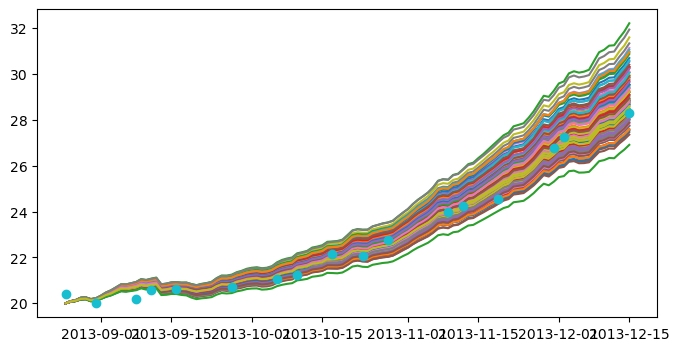

In [9]:
fig, ax = plt.subplots(figsize=(8,4))
for pan_factor, Cl_rain in zip(pan_factors, Cl_rains):
    Cl = get_conc_cl(df.copy(), pan_factor=pan_factor, Cl_rain=Cl_rain, sd1=0.033)
    ax.plot(df.index, Cl)
ax.plot(df.index, df["Cl_sample"], 'o')

Sometimes though, it is convenient to add a counter. For example, if we wish to store the outcome of each model run in a DataFrame. The script below uses a counter to add a unique column name to each column of `dfnew`, the DataFrame with the results.

In [13]:
dfnew = pd.DataFrame(index=df.index)
for n, (pan_factor, Cl_rain) in enumerate(zip(pan_factors, Cl_rains)):
    Cl = get_conc_cl(df.copy(), pan_factor=pan_factor, Cl_rain=Cl_rain, sd1=0.033)
    col_name = f"simulation_{n}"
    dfnew[col_name] = Cl

print(dfnew.head())

            simulation_0  simulation_1  simulation_2  simulation_3  \
2013-08-25     20.000000     20.000000     20.000000     20.000000   
2013-08-26     20.080372     20.074930     20.088217     20.083098   
2013-08-27     20.122444     20.114814     20.132196     20.126281   
2013-08-28     20.207954     20.201094     20.226320     20.213621   
2013-08-29     20.218506     20.210788     20.237040     20.224140   

            simulation_4  simulation_5  simulation_6  simulation_7  \
2013-08-25     20.000000     20.000000     20.000000     20.000000   
2013-08-26     20.080753     20.072497     20.070268     20.079311   
2013-08-27     20.123666     20.104817     20.107038     20.120366   
2013-08-28     20.211329     20.179799     20.185197     20.199205   
2013-08-29     20.221866     20.190170     20.194957     20.209727   

            simulation_8  simulation_9  ...  simulation_89  simulation_90  \
2013-08-25     20.000000     20.000000  ...      20.000000      20.000000   
2013

Now let's try to draw the mean value for each time step, and add some uncertainty bands (rather than plotting 99 colourful lines). One way to do this is to calculate the descriptive statistics using the `describe` function of Pandas. This function works on columns rather than rows so we have to transpose (that is, swap the rows for the columns) the DataFrame first using `dfnew.T`. The result of calling the `describe` method is stored in the DataFrame `dfstats`, which we also transpose so that the statistics for each time step appear per row for each time step.

In [18]:
dfstats = dfnew.T.describe()
dfstats = dfstats.T

print(dfstats.head())

            count       mean       std        min        25%        50%  \
2013-08-25   99.0  20.000000  0.000000  20.000000  20.000000  20.000000   
2013-08-26   99.0  20.077162  0.007203  20.063480  20.072387  20.076088   
2013-08-27   99.0  20.117504  0.010509  20.095351  20.110247  20.115797   
2013-08-28   99.0  20.202265  0.017350  20.166356  20.190649  20.200201   
2013-08-29   99.0  20.212688  0.018112  20.174689  20.200328  20.210788   

                  75%        max  
2013-08-25  20.000000  20.000000  
2013-08-26  20.081764  20.097843  
2013-08-27  20.123963  20.145070  
2013-08-28  20.211317  20.248613  
2013-08-29  20.222719  20.260222  


With these numbers we can now plot the median (50% percentile) model outcome as a blue line, and include shaded areas that represent the min-max and 25%-75% percentile ranges. Note the use of the `alpha` value, which controls the transparency of an object in the figure.

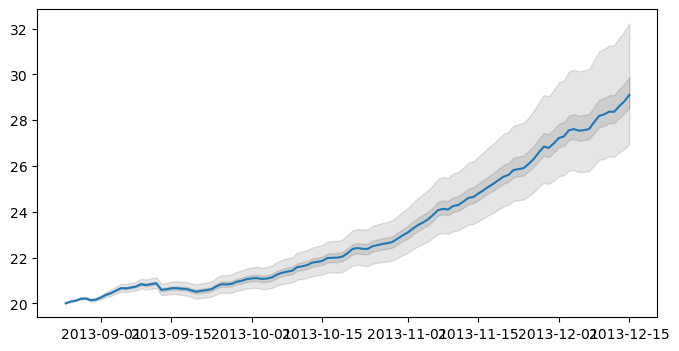

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
ax.fill_between(dfstats.index, dfstats["min"], dfstats["max"], color='k', alpha=0.1)
ax.fill_between(dfstats.index, dfstats["25%"], dfstats["75%"], color='k', alpha=0.1)
ax.plot(dfstats.index, dfstats["50%"], color='C0');

***Exercise***: Use the `describe` method to calculate the 16% and 84% percentiles instead of the default values.

In [27]:

dfstats1 = dfnew.T.describe()
dfstats1 = dfstats1.T

# percentile list
perc = [.16, .84]
  
# list of dtypes to include
include = ['object', 'float', 'int']
  
# calling describe method
desc = dfnew.T.describe(percentiles=perc, include=include)
  
# display
desc


,2013-08-25,2013-08-26,2013-08-27,2013-08-28,2013-08-29,2013-08-30,2013-08-31,2013-09-01,2013-09-02,2013-09-03,...,2013-12-06,2013-12-07,2013-12-08,2013-12-09,2013-12-10,2013-12-11,2013-12-12,2013-12-13,2013-12-14,2013-12-15
count,99.0,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,20.0,20.077162,20.117504,20.202265,20.212688,20.135765,20.163635,20.256981,20.368799,20.447404,...,27.670050,27.717354,28.004758,28.294376,28.365638,28.486582,28.489252,28.741112,28.953542,29.226512
std,0.0,0.007203,0.010509,0.017350,0.018112,0.023566,0.025762,0.032929,0.042045,0.048026,...,0.893391,0.900978,0.931271,0.963862,0.974727,0.988336,0.995981,1.022452,1.045092,1.077516
min,20.0,20.063480,20.095351,20.166356,20.174689,20.072998,20.096935,20.169899,20.259101,20.323681,...,25.741233,25.771961,26.023534,26.270239,26.318325,26.412474,26.402759,26.592849,26.741441,26.935859
16%,20.0,20.070320,20.108268,20.185838,20.195291,20.115280,20.140848,20.228510,20.329898,20.402711,...,26.781277,26.822105,27.082229,27.345796,27.400152,27.510533,27.503740,27.724027,27.904706,28.155092
50%,20.0,20.076088,20.115797,20.200201,20.210788,20.134985,20.162060,20.254850,20.367787,20.445846,...,27.568384,27.612443,27.913452,28.187627,28.255084,28.370942,28.371728,28.612993,28.820621,29.102389
84%,20.0,20.083763,20.130064,20.221971,20.232507,20.158076,20.188565,20.290994,20.408513,20.493713,...,28.452679,28.506299,28.841336,29.152474,29.232063,29.364279,29.368479,29.625894,29.865011,30.161487
max,20.0,20.097843,20.145070,20.248613,20.260222,20.196835,20.232250,20.343345,20.494032,20.586769,...,30.174524,30.247793,30.621698,31.010806,31.111484,31.273316,31.286580,31.609332,31.883840,32.237475


***Exercise***: By default, Matplotlib draws a line around the filled areas. Look up the documentation and find a way to plot the filled area without a visible line around its borders. Note that there are multiple ways of achieving this.

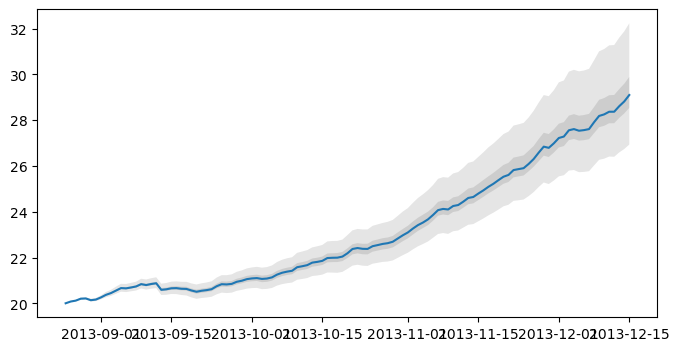

In [26]:
fig, ax = plt.subplots(figsize=(8,4))
ax.fill_between(dfstats.index, dfstats["min"], dfstats["max"], color='k', alpha=0.1, edgecolor=None)
ax.fill_between(dfstats.index, dfstats["25%"], dfstats["75%"], color='k', alpha=0.1, edgecolor=None)
ax.plot(dfstats.index, dfstats["50%"], color='C0');

# Visualizing data

## Matplotlib

We have already seen that Matplotlib is heavily object-oriented. It offers many options for drawing, but its vocabulary can be difficult to master. The links below provide some insighs.

<A href="https://matplotlib.org/stable/tutorials/introductory/quick_start.html">https://matplotlib.org/stable/tutorials/introductory/quick_start.html</A>

<A href="https://stackoverflow.com/questions/37970424/what-is-the-difference-between-drawing-plots-using-plot-axes-or-figure-in-matpl">https://stackoverflow.com/questions/37970424/what-is-the-difference-between-drawing-plots-using-plot-axes-or-figure-in-matpl</A>

It is useful to know that an `Artist` is basically everything visible on a `Figure` (the area being drawn on). An `Axes` represents one (sub-)plot in a `Figure`. It contains the plotted data, axis ticks, labels, title, legend, etc. Its methods are the main interface for manipulating the plot. An `Axis` is one of the axes in a graph (for example the x or y axis).

This figure from the matplotlib documentation pages is a great help in understanding the matplotlib terminology: <A href="https://matplotlib.org/stable/tutorials/introductory/quick_start.html">https://matplotlib.org/stable/tutorials/introductory/quick_start.html</A>

<IMG src="https://matplotlib.org/stable/_images/anatomy.png" width=800>

The difference between a `Figure` and an `Axes` may be illustrated by creating a handle to both types of objects using `subplots` (confusingly there is also a function called `subplot`). We color the `Figure` blue, and the `Axes` red.

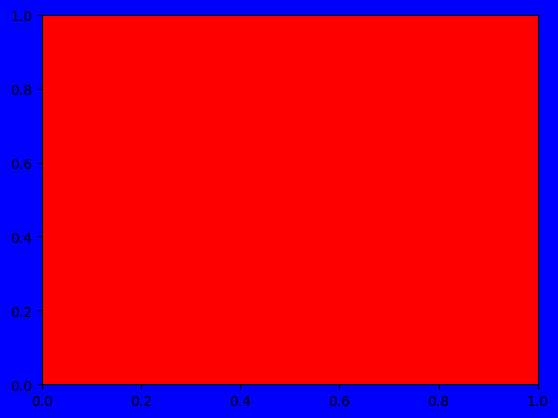

In [28]:
fig, ax = plt.subplots()
fig.set_facecolor('b')
ax.set_facecolor('r')

Let's use the graph with the model outcomes to explore some ways of prettifying the graph. The code cell below adds a y-axis label, grid lines and formats the dates on the x-axis. For conveniences, here is a summary list of formatting codes for common date and time elements.

  * %Y - 4 digit year with upper case Y
  * %y - 2 digit year with lower case y
  * %m - month as a number with lower case m
  * %b - month as abbreviated name with lower case b
  * %d - day with lower case d

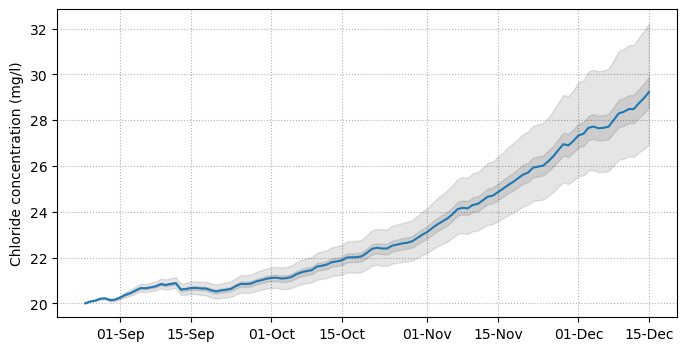

In [29]:

fig, ax = plt.subplots(figsize=(8,4))
ax.fill_between(dfstats.index, dfstats["min"], dfstats["max"], color='k', alpha=0.1)
ax.fill_between(dfstats.index, dfstats["25%"], dfstats["75%"], color='k', alpha=0.1)
ax.plot(dfstats.index, dfstats["mean"], color='C0')

# Add a label on the y-axis
ax.set_ylabel("Chloride concentration (mg/l)")

# Add grid lines
ax.grid(linestyle=':')
ax.set_axisbelow(True) # Makes sure that grid lines do not cover graph elements

# Format the dates on the x-axis
from matplotlib.dates import DateFormatter
date_format = DateFormatter("%d-%b")
ax.xaxis.set_major_formatter(date_format)

Let's explore a bit more by plotting the data from the `df` DataFrame. Creating a bar graph is done using `bar`. Rainfall was exceptionally high on one day, so the vertical axis is truncated at 8 mm, and an arrow is added to indicate the value for the bar that extends above this maximum.

2013-09-12    15.0
Name: rain, dtype: float64


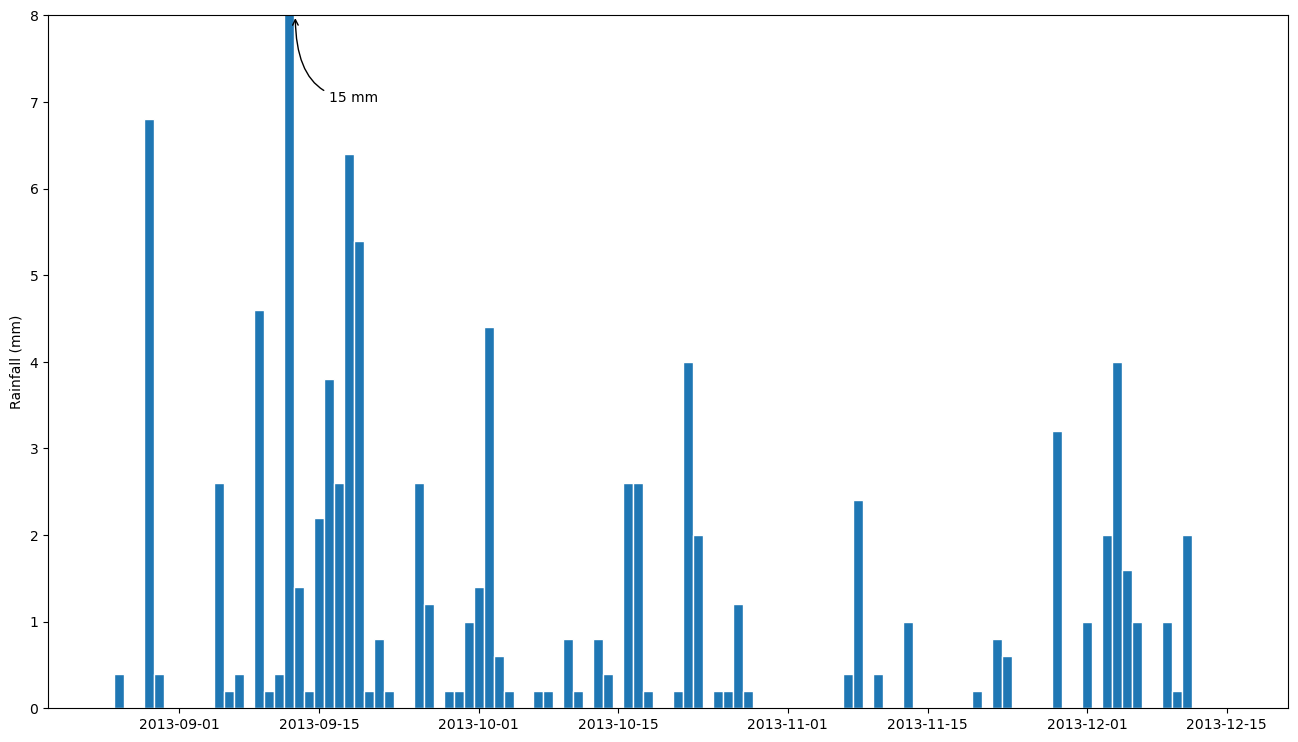

In [30]:
xmin = pd.to_datetime("2013/08/24")
xmax = pd.to_datetime("2013/12/16")

idx = df['rain'] > 8
print(df.loc[idx, 'rain'])
fig, ax = plt.subplots(figsize=(16, 9))

ax.bar(df.index, df["rain"], ec='w', width=1, label="Rainfall")
ax.set_ylim(0, 8)
ax.set_ylabel("Rainfall (mm)")

x0 = pd.to_datetime("2013/09/12 15:00")
x1 = pd.to_datetime("2013/09/16")
ax.annotate(
    text='15 mm', 
    xy=(x0, 8), 
    xytext=(x1, 7),
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="angle3,angleA=0,angleB=-90",
    )
);

The next code cell plots the measured evaporation. It demonstrates how each bar in the chart can be given a color depending on its value. It is not very useful in this case, but it is a demonstration of the use of a color map.

Text(0, 0.5, 'Pan evaporation (mm)')

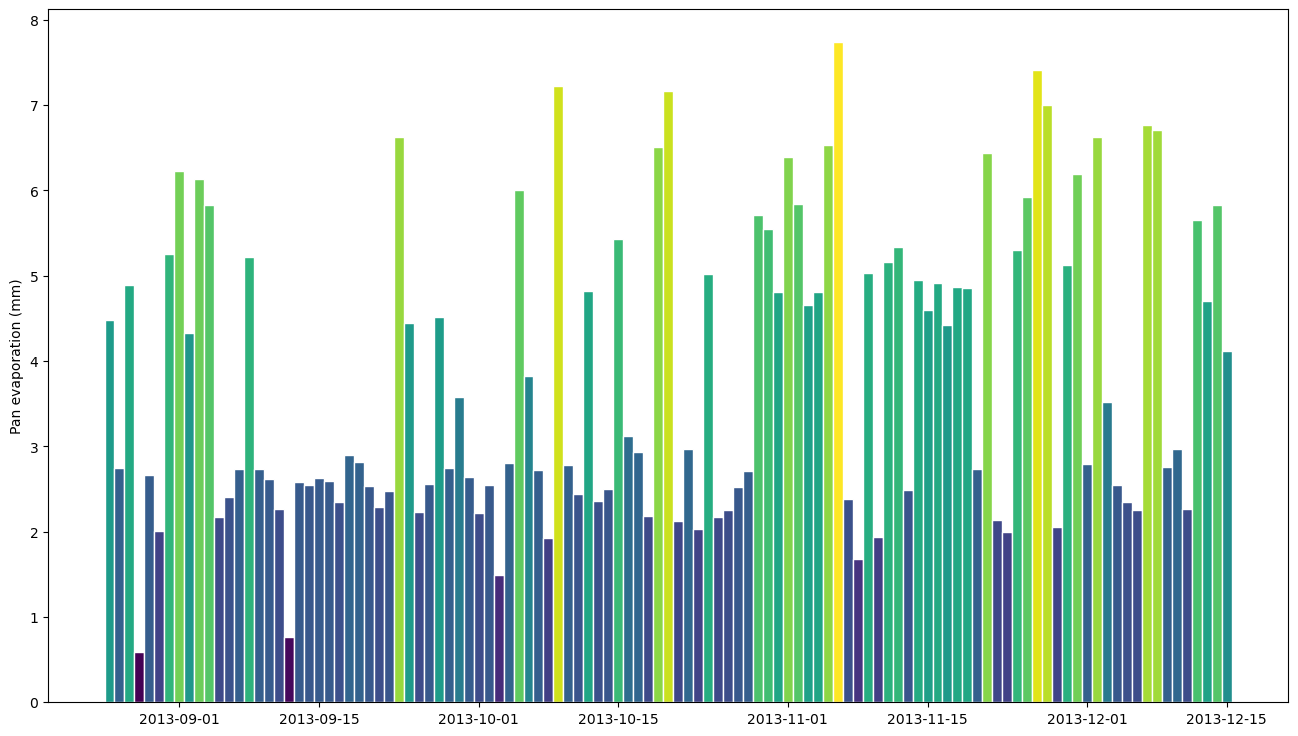

In [31]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(16, 9))

scaled_values = (df["evaporation"] - df["evaporation"].min()) / (df["evaporation"].max() - df["evaporation"].min())
colors = cm.viridis(scaled_values)
ax.bar(df.index, df["evaporation"], color=colors, ec='w', width=1)
ax.set_ylabel("Pan evaporation (mm)")

***Exercise***: Have a look at the available color maps on <A href="https://matplotlib.org/stable/tutorials/colors/colormaps.html">https://matplotlib.org/stable/tutorials/colors/colormaps.html</A>. Modify the previous code example to have the bars plotted using the color scheme of your choice.

The (lengthy) code below draws a three-axes figure. It shows, amongst others, how a horizontal line can be added using `axhline` and how the colors of the vertical axis can be changed. Note how `for` loop is used to set the properties of the `Axes` that should be the same or different for each of the three graphs.

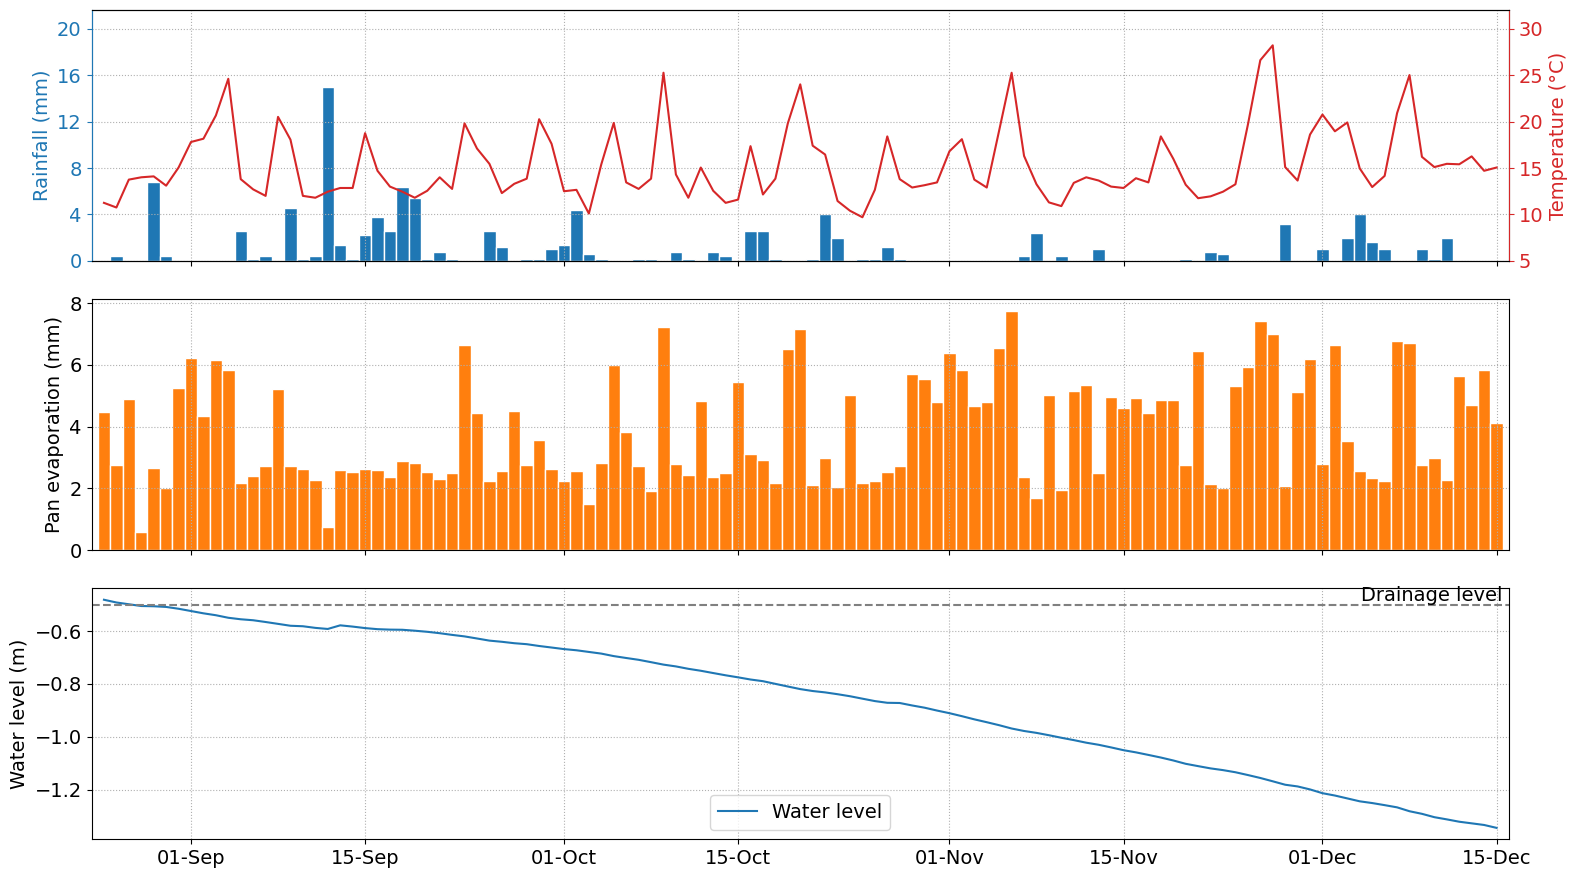

In [37]:
fig, (axr, axe, axwl) = plt.subplots(nrows=3, figsize=(16, 9))
axt = axr.twinx()

axr.bar(df.index, df["rain"], ec='w', width=1, label="Rainfall")
axr.set_yticks([0, 4, 8, 12, 16, 20])
axr.set_ylim(0, 27 / 25 * 20)
axr.set_ylabel("Rainfall (mm)")
axt.plot(df["temperature"], 'C3-', label="Temperature")
axt.set_yticks([5, 10, 15, 20, 25, 30])
axt.set_ylim(5, 32)
axt.set_ylabel("Temperature (\u00B0C)")

axe.bar(df.index, df["evaporation"], color="C1", ec='w', width=1)
axe.set_ylabel("Pan evaporation (mm)")

axwl.plot(df.index, df["wl"], label="Water level")
axwl.axhline(-0.5, color='gray', ls='--')
axwl.set_ylabel("Water level (m)")
axwl.legend(loc='lower center', ncol=2)
axwl.text(xmax, -0.5, "Drainage level ", ha='right', va='bottom')

for ax in (axr, axe, axt, axwl):
    if ax != axt:
        ax.grid(ls=":")
    ax.set_xlim(xmin, xmax)
    if ax != axwl:
        ax.set_xticklabels([])

axwl.xaxis.set_major_formatter(DateFormatter('%d-%b'))

axt.spines['right'].set_color('C3')
axt.tick_params(axis='y', colors='C3')
axt.yaxis.label.set_color('C3')
axt.spines['left'].set_color('C0')
axr.spines['left'].set_color('C0')
axr.tick_params(axis='y', colors='C0')
axr.yaxis.label.set_color('C0')

plt.tight_layout()

***Exercise***: Create a shared x-axis just like in the upper graph of the previous figure to also include a line that shows the water volume in the farm dam (df["volume"]). Modify the code cell below to create this graph.

We now see two lines but without a legend, it is impossible to tell which line is which. Adding a legend to a graph with dual axes is a bit involved, but it can be done.

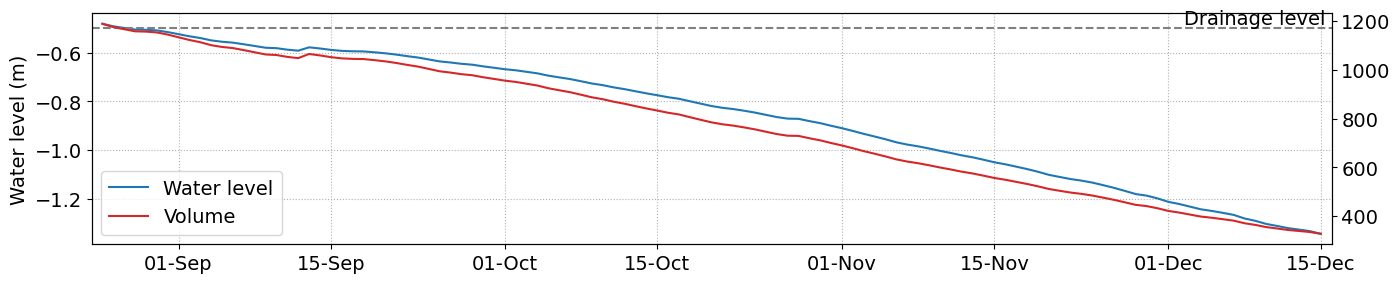

In [35]:
fig, ax = plt.subplots(figsize=(16, 3))

ax.plot(df.index, df["wl"], label="Water level")
ax.axhline(-0.5, color='gray', ls='--')
ax.set_ylabel("Water level (m)")
ax.legend(loc='lower center', ncol=2)
ax.text(xmax, -0.5, "Drainage level ", ha='right', va='bottom')

ax.grid(ls=":")
ax.set_xlim(xmin, xmax)

ax.xaxis.set_major_formatter(DateFormatter('%d-%b'))

axv = ax.twinx()
l1 = axv.plot(df.index, df["volume"], 'C3', label="Volume")

# See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html
handles0, labels0 = ax.get_legend_handles_labels()
handles1, labels1 = axv.get_legend_handles_labels()
ax.legend(handles0+handles1, labels0+labels1)

If you want a consistent font size for all text in your figure, you can set the default using the line of code below. Note that you must include this a the beginning of a script in order to take effect. For help on setting other defaults, see <A href="https://matplotlib.org/stable/tutorials/introductory/customizing.html">https://matplotlib.org/stable/tutorials/introductory/customizing.html</A>.

In [36]:
plt.rcParams.update({'font.size': 14})